# Processing ProRail pedestrian trajectory data

In this notebook we will give you an introduction to working with the trajectory data from ProRail. The data we use is provided on the TU/e Research drive and can be loaded using the sociophysicsDataHandler package provided in the course. Please refer to the course manual for additional explanation on how to work with the Research drive and the dataHandler package. <br>

After the data is loaded we will show some basic analysis tools e.g. plotting heatmaps and trajectories. Next to these analytic tools we also show some common pitfalls and how to deal with them.

First let's install the socioPhysicsDatahandler package and make a datahandler object.

In [1]:
!pip install -q sociophysicsDataHandler

In [2]:
from sociophysicsDataHandler import SociophysicsDataHandler
dh = SociophysicsDataHandler()

##### we need now to create a file containing the user credentials

1. In Colab, go to the left panel "Files"
2. Right click -> New File
3. File name needs to be "auth.txt"
4. Place in the file the access credentials (note, from time to me we change them): 
````
guest
YDPGL-XREXC-QGMZS-UAKES
````

In [3]:
# If you have done things correctly, this command should return you your own credentials
!cat auth.txt

guest
YDPGL-XREXC-QGMZS-UAKES

Now we will list all the files on TU/e Research drive from a particular area (platform2.1) and day (April 28, 2020). Tip: you can also list all the files in every folder on the Research drive by specifying an empty string (' ') as folder path. Asdz is an abbreviation for 'Amsterdam Zuid' used by ProRail to indicate data recorded at this station.

In [4]:
folder_path = 'asdz/platform2.1/20200428/'
dh.list_files(folder_path)

targeting path /storage/surfsara/ProRail_USE_LL_data/asdz/platform2.1/20200428/
Files listed. Accessible as <this-object>.filelist


,path,name,attributes
0,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,ASDZ_Perron2.1_2020042800_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Wed, 29 Apr 2020 09..."
1,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,ASDZ_Perron2.1_2020042801_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Wed, 29 Apr 2020 09..."
2,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,ASDZ_Perron2.1_2020042802_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Wed, 29 Apr 2020 09..."
3,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,ASDZ_Perron2.1_2020042803_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Wed, 29 Apr 2020 09..."
4,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,ASDZ_Perron2.1_2020042804_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Wed, 29 Apr 2020 09..."
5,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,ASDZ_Perron2.1_2020042805_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Wed, 29 Apr 2020 09..."
6,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,ASDZ_Perron2.1_2020042806_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Wed, 29 Apr 2020 09..."
7,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,ASDZ_Perron2.1_2020042807_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Wed, 29 Apr 2020 09..."
8,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,ASDZ_Perron2.1_2020042808_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Wed, 29 Apr 2020 09..."
9,/storage/surfsara/ProRail_USE_LL_data/asdz/pla...,ASDZ_Perron2.1_2020042809_trajectorie.parquet,"{'{DAV:}getlastmodified': 'Wed, 29 Apr 2020 09..."


We can see the data is formatted with a file for each hour of the day. We can load one of these files into memory by combining the folder path with the path of the file.

In [5]:
file_target = "ASDZ_Perron2.1_2020042810_trajectorie.parquet"
file_path = folder_path + file_target
dh.fetch_prorail_data_from_path(file_path)

trying to fetch: /storage/surfsara/ProRail_USE_LL_data/asdz/platform2.1/20200428/ASDZ_Perron2.1_2020042810_trajectorie.parquet
data fetched. Accessible as <this-object>.df


Lets print the first few rows of the data we just loaded

In [6]:
dh.df.head()

,date_time_utc,tracked_object,x_pos,y_pos
0,1.588068e+12,23360,909.0,-1022.0
1,1.588068e+12,23360,788.0,-941.0
2,1.588068e+12,23360,646.0,-860.0
3,1.588068e+12,23360,646.0,-860.0
4,1.588068e+12,23360,473.0,-811.0


<b>The data has four columns:</b> <br>
- `date_time_utc` = UNIX timestamp in miliseconds since the first of January 1970.<br>
- `tracked_object` = Unique object id <br>
- `x_pos` = x-coordinate in milimeter <br>
- `y_pos` = y-coordinate in milimeter <br>

To understand where this data is recorded we would like to print a background image. Therefore we must first fetch the background image form Research Drive. To find the path to the background image you can use the dh.list_files() and dh.print_files() methods again. 

In [7]:
dh.fetch_background_image_from_path('asdz/background_images/asdz-platform2.1-stairs.bmp')

trying to fetch: /storage/surfsara/ProRail_USE_LL_data/asdz/background_images/asdz-platform2.1-stairs.bmp
background fetched. Accessible as <this-object>.bg


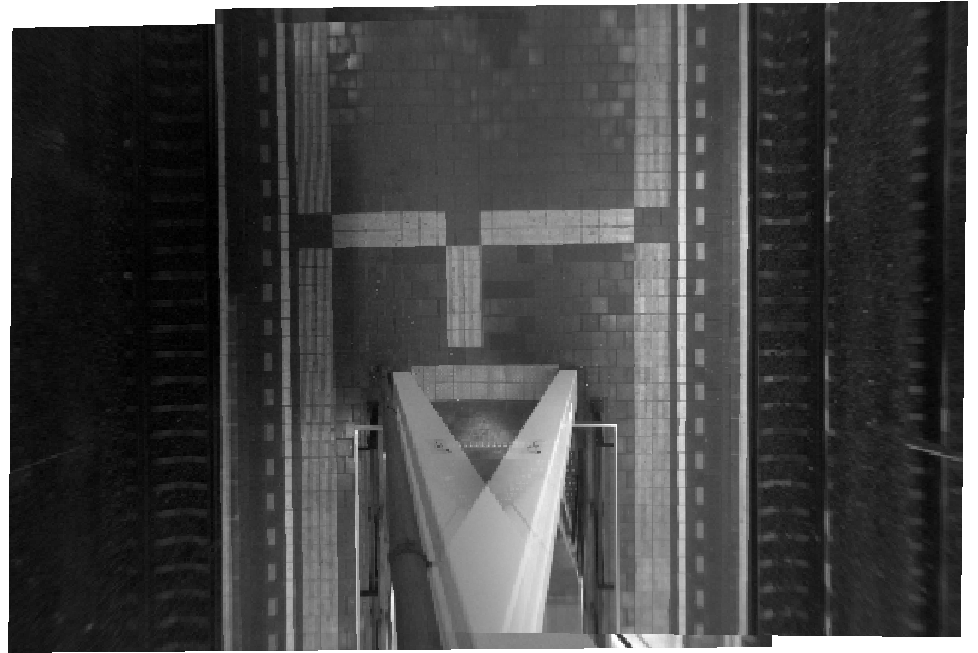

In [8]:
dh.bg

In the background image we see a top down image from platform 2 at train station Amsterdam Zuid. As the file name already indicated this is from a measurement area next to the staircase that is located in the bottom of the image. On the far left and far right we see the train tracks. 

## Plotting the trajectory data

The first plot we can make is a plot of all the individual trajectories where each trajectory has a different color. For convenience we also plotted the background image next to the trajectories. Please note that the background image can have a different coordinate system than the trajectory data. In this case the data is upside down, i.e. mirrored over the x-axis, due to the standard axis orientation in the imshow function. 

In [9]:
# First the pyplot package must be imported
import matplotlib.pyplot as plt

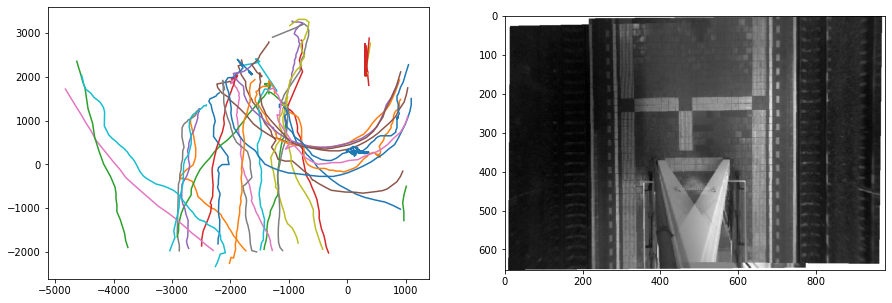

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

# Plot of the trajectories
dh.df.groupby('tracked_object').apply(lambda x : ax[0].plot(x.x_pos,x.y_pos));

# Plot of the background
ax[1].imshow(dh.bg, cmap = 'gray')

## Heatmap

We can also plot a heatmap to see which place of the area is most frequently used by a pedestrian. Below we can see on the left a normal heatmat, in the middle a heatmap with a logarithmic scale and on the right the backround (this time mirrored over the x-axis).

(200.0, 800.0)

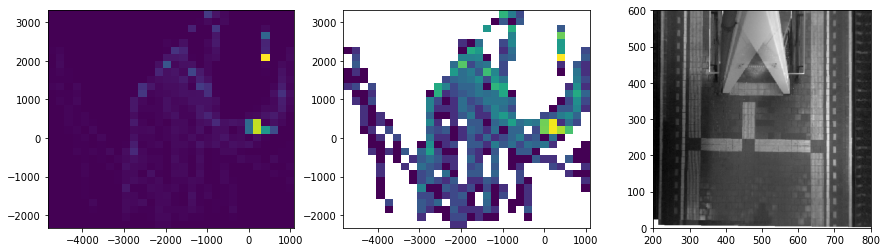

In [22]:
import matplotlib as mpl

fig, ax = plt.subplots(1, 3, figsize = (15, 4))

# Plot a normal heatmap
ax[0].hist2d(dh.df.x_pos, dh.df.y_pos, bins = (30, 30));

# Plot a heatmap with a logarithmic scale
ax[1].hist2d(dh.df.x_pos, dh.df.y_pos, bins = (30, 30), norm=mpl.colors.LogNorm());

# Plot the background
ax[2].imshow(dh.bg, cmap = 'gray')
ax[2].set_ylim(0, 600) # mirrored over the x-axis
ax[2].set_xlim(200,800) # cropped on the right and left

## First and last observation per trajectory

We can also plot the first (red) and the last (blue) position of every pedestrian. This can tell us something about the quality of the tracking. To do this we add two columns to the dataframe. The first column "Rstep_len" contains the length of the trajectory and the second column "R_step" holds the number of each step such that R_step = 0 is the first timestep of that trajectory. We need the numpy package for this.

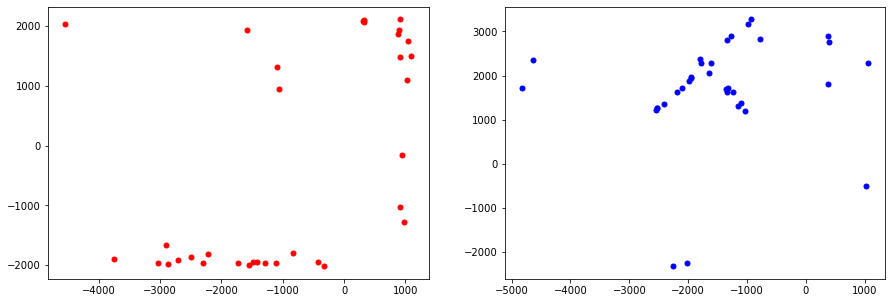

In [14]:
import numpy as np
# Add the two additional columns
dh.df["Rstep_len"] = dh.df.groupby('tracked_object').tracked_object.transform('size')
dh.df["Rstep"] = dh.df.groupby('tracked_object')["Rstep_len"].transform(lambda x: np.arange(x.iloc[0]))

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

# Plot the first observations
ax[0].plot(dh.df.query('Rstep == 0').x_pos, 
           dh.df.query('Rstep == 0').y_pos, '.r', ms = 10)

# Plot the last observations
ax[1].plot(dh.df.query('Rstep == Rstep_len - 1').x_pos, 
           dh.df.query('Rstep == Rstep_len - 1').y_pos, '.b', ms = 10)

## Plotting the number of detected pedestrians over time

When we want to use the time of the observations it is useflul to convert the UNIX timestamps into datetime objects and set the proper timezone. We need the pandas package for this. We also need to order the dataframe based on the timestamps.

In [15]:
import pandas as pd
# Convert to datetime
dh.df['datetime'] = pd.to_datetime(dh.df.date_time_utc, unit='ms')

# First set timezone to UTC
dh.df['datetime'] = dh.df.datetime.dt.tz_localize('UTC') 

# Convert to CET
dh.df['datetime'] = dh.df.datetime.dt.tz_convert('Europe/Berlin') 

# Sort values
dh.df = dh.df.sort_values('date_time_utc')

Now we can make a plot of the number of detected people vs the time to get an idea of the moments when people are on the platform. Therefore we need to add a column with the number of objects in each timeframe. To plot the datetimes properly we advise to use the 'mdates' package as show below.


Text(0, 0.5, 'Pedestrians in frame')

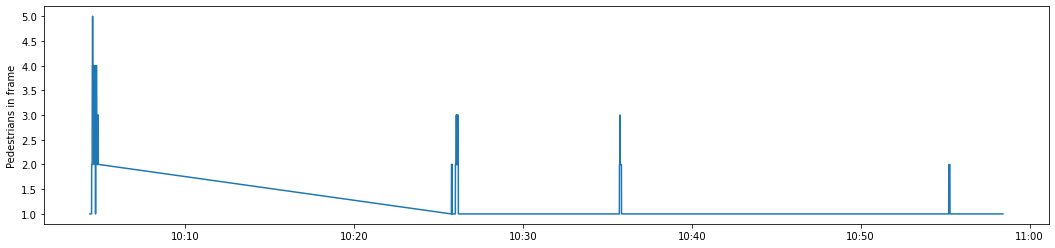

In [16]:
import matplotlib.dates as mdates
dh.df['frame_objs'] = dh.df.groupby('date_time_utc').tracked_object.transform('size')

fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(dh.df.datetime, dh.df.frame_objs)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_ylabel('Pedestrians in frame')

The plot above never gets below 1 pedestrian. This is because in the data there exist no observation with 0 pedestrians. All the missing time instances are being automatically filled by the plotting since it connects all the dots with straight lines. When we make the same plot over a shorter time domain this becomes even more visible.

Text(0, 0.5, 'Pedestrians in frame')

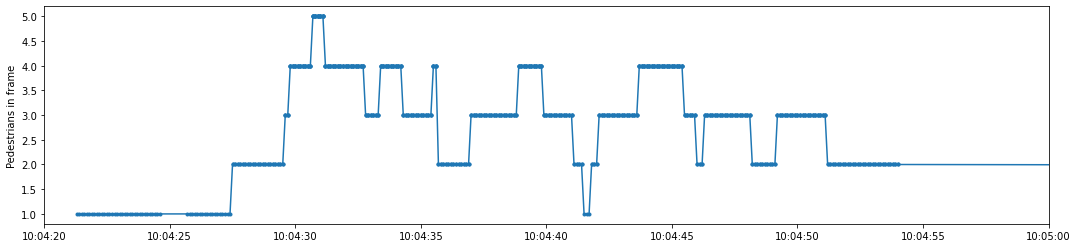

In [17]:
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(dh.df.datetime, dh.df.frame_objs, '.-')
ax.set_xlim(pd.to_datetime('2020-04-28 10:04:20'), 
            pd.to_datetime('2020-04-28 10:05:00'))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.set_ylabel('Pedestrians in frame')

## Padding with zero's

To fix this we should pad the data with the missing time instances, setting those to 0 pedestrians. Start by creating a dataframe containing all the unix timestamps of that day. Consecutively join this dataframe with the actual trajectories dataset and fill all NaN values with 0.

In [18]:
all_frames = pd.DataFrame(np.arange(dh.df.date_time_utc.iloc[0], 
                                    dh.df.date_time_utc.iloc[-1], 100), 
                          columns = ['date_time_utc'])
all_frames = all_frames.set_index('date_time_utc')
df_original = dh.df[['date_time_utc','frame_objs']].set_index('date_time_utc')
df_all_frames = all_frames.join(df_original)
df_all_frames = df_all_frames.fillna(0)

Convert the UNIX timestamp again to datetime objects.

In [19]:
df_all_frames['datetime'] = pd.to_datetime(df_all_frames.index, unit='ms')
df_all_frames['datetime'] = df_all_frames.datetime.dt.tz_localize('UTC') # First set timezone to UTC
df_all_frames['datetime'] = df_all_frames.datetime.dt.tz_convert('Europe/Berlin') # Convert to CET

Plot again to see the difference.

Text(0, 0.5, 'Pedestrians in frame')

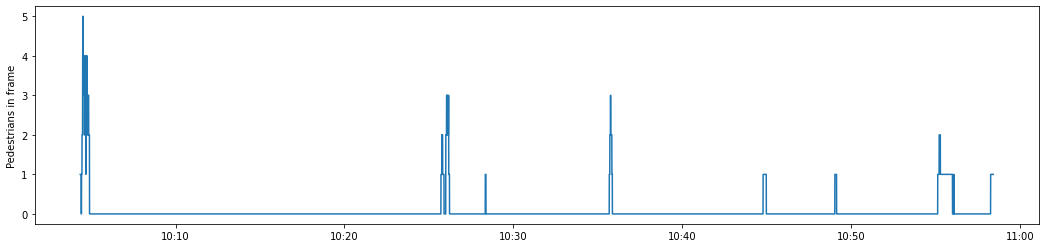

In [20]:
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_all_frames.datetime, df_all_frames.frame_objs)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_ylabel('Pedestrians in frame')

Text(0, 0.5, 'Pedestrians in frame')

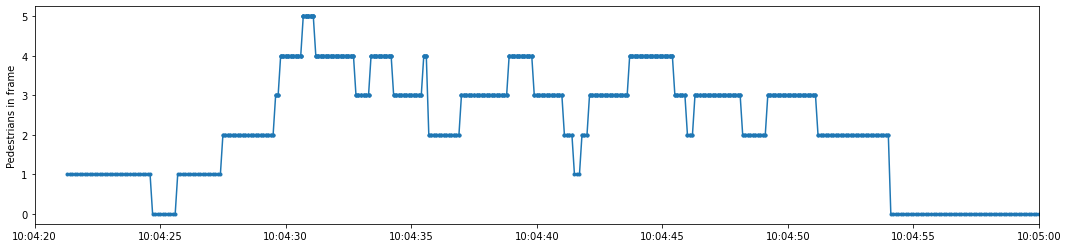

In [21]:
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_all_frames.datetime, df_all_frames.frame_objs, '.-')
ax.set_xlim(pd.to_datetime('2020-04-28 10:04:20'), 
            pd.to_datetime('2020-04-28 10:05:00'))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.set_ylabel('Pedestrians in frame')

# Conclusion

Always be carefull while working with data and check if what you are seeing is plausible. In this notebook you have seen some analytic tools that can help you understand and validate the trajectory data better. 